In [1]:
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 
import numpy as np

In [2]:
import yaml

In [3]:
import os 

os.chdir('E://bond-dex/bond-amm-simulation/')

In [4]:
from simulation.__NaiveTradeSimulator import NaiveTradeSimulator

In [5]:
from scripts.generate_stats_v1 import plot_stats

## Trade behaviour

In [6]:
trade_df = pd.read_csv('sources/input/actor_trade/single_trade.csv')

In [7]:
LENGTH = 24 * 60

In [8]:
trade_df['day'] = (trade_df.timestamp / LENGTH).astype('int') * LENGTH
trade_df['net_volume'] = trade_df.apply(lambda row: row['cash_volume'] if row['action'] == 'lend'
                                                       else -row['cash_volume'], axis=1)

In [9]:
trade_df = trade_df[trade_df.day < 180 * LENGTH]

In [10]:
agg_trade = trade_df.groupby(['day', 'action'], as_index=False).agg({'net_volume': 'sum'})

In [11]:
net_trade = agg_trade.groupby('day', as_index=False).agg({'net_volume': 'sum'})

In [235]:
agg_trade['cum_volume'] = agg_trade.groupby('action')['net_volume'].transform(lambda x: np.cumsum(x))

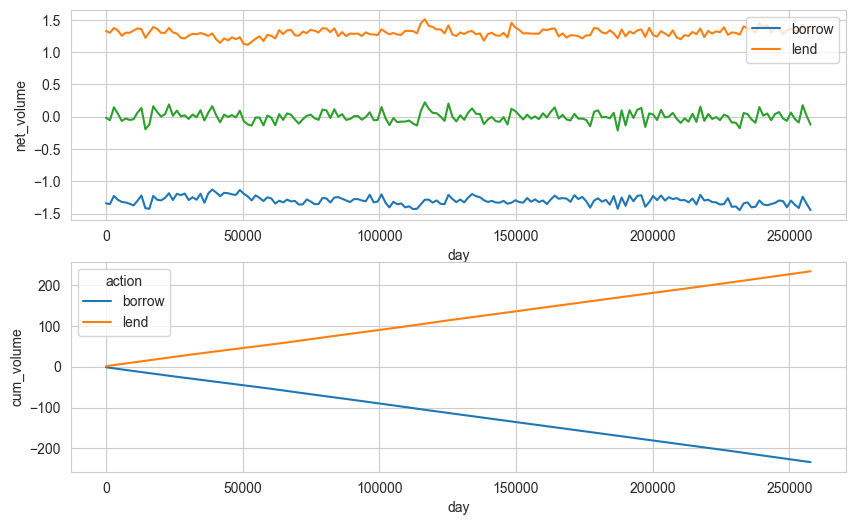

In [249]:
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

sns.lineplot(data=agg_trade, x='day', y='net_volume', hue='action', 
             ax=axs[0])

sns.lineplot(data=net_trade, x='day', y='net_volume', 
             ax=axs[0])

axs[0].grid(True)

sns.lineplot(data=agg_trade, x='day', y='cum_volume', hue='action', 
             ax=axs[1])
axs[1].grid(True)

plt.show()

## Simulation for Yield

In [13]:
%load_ext autoreload

In [14]:
%autoreload 2

from simulation.__NaiveTradeSimulator import NaiveTradeSimulator

In [15]:
%%writefile config/yield_v1.yml

config:
  simulation:
    simulation_length: 200000
    begin_trade_time: 0
    maturity: 259200

  fee:
    rate: 0.

  trader:
    trade_data: 'sources/input/actor_trade/single_trade.csv'

  pricing_config:
      pricing_method: 'yield-v1'
      params:

  tracking:
    dir: 'data/tracking/yield_v1'


Overwriting config/yield_v1.yml


In [16]:
with open('config/yield_v1.yml') as file:
    metadata = yaml.safe_load(file)

simulator = NaiveTradeSimulator(metadata['config'])
simulator.run()

Initialized simulation!

------------- Begin running simulation -------------


100%|███████████████████████████████████████████████████████████████████████| 200000/200000 [00:19<00:00, 10189.92it/s]



Saving tracking data to data/tracking/yield_v1

------------------ Done simulation ------------------


<Figure size 1000x800 with 0 Axes>

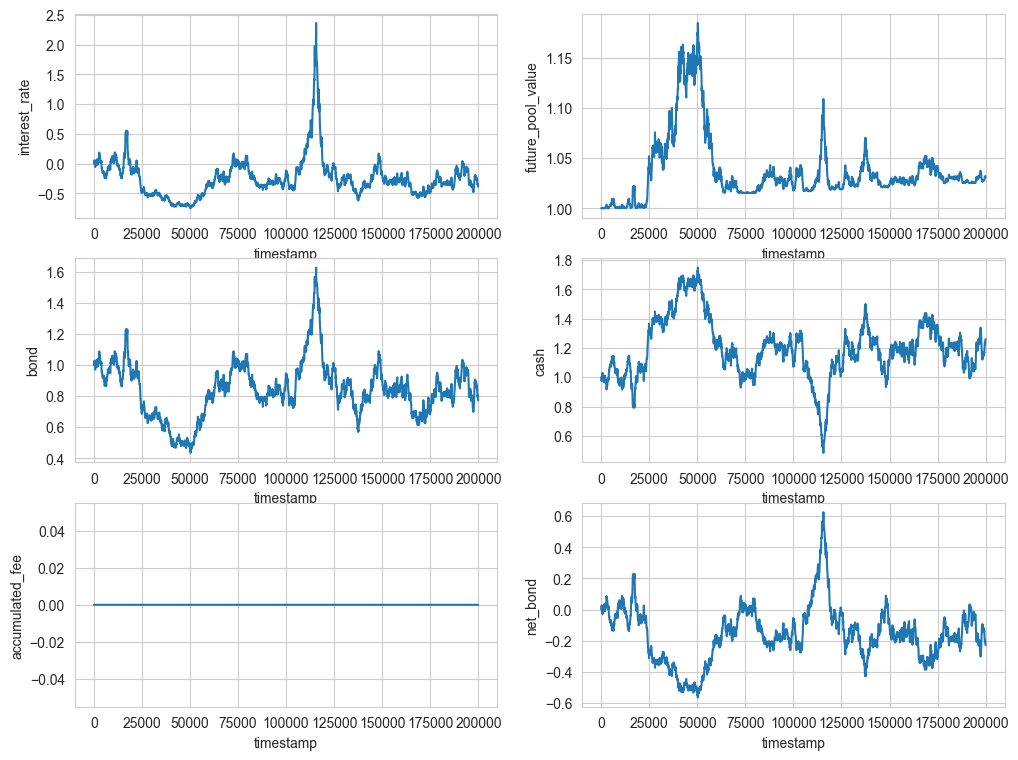

In [17]:
fig = plt.figure(figsize=(10, 8))

plot_stats('data/tracking/yield_v1', 'ALL_INFORMATION.json', fig_size=(12, 9))

## Simulation for Logit Notional

In [100]:
%%writefile config/logit_notional_v1.yml

version_name: 'linear-notional-v1'

config:
  simulation:
    simulation_length: 200000
    begin_trade_time: 0
    maturity: 259200

  fee:
    rate: 0.

  pricing_config:
      pricing_method: 'logit-notional'
      params:
        scalar: 50
        anchor: 1.02

  trader:
    trade_data: 'sources/input/actor_trade/single_trade.csv'

  tracking:
    dir: 'data/tracking/logit_notional'

Overwriting config/logit_notional_v1.yml


In [101]:
%autoreload 2

from simulation.__NaiveTradeSimulator import NaiveTradeSimulator

In [102]:
with open('config/logit_notional_v1.yml') as file:
    metadata = yaml.safe_load(file)

simulator = NaiveTradeSimulator(metadata['config'])
simulator.run()

Initialized simulation!

------------- Begin running simulation -------------


100%|████████████████████████████████████████████████████████████████████████| 200000/200000 [00:37<00:00, 5336.33it/s]



Saving tracking data to data/tracking/logit_notional

------------------ Done simulation ------------------


<Figure size 1000x800 with 0 Axes>

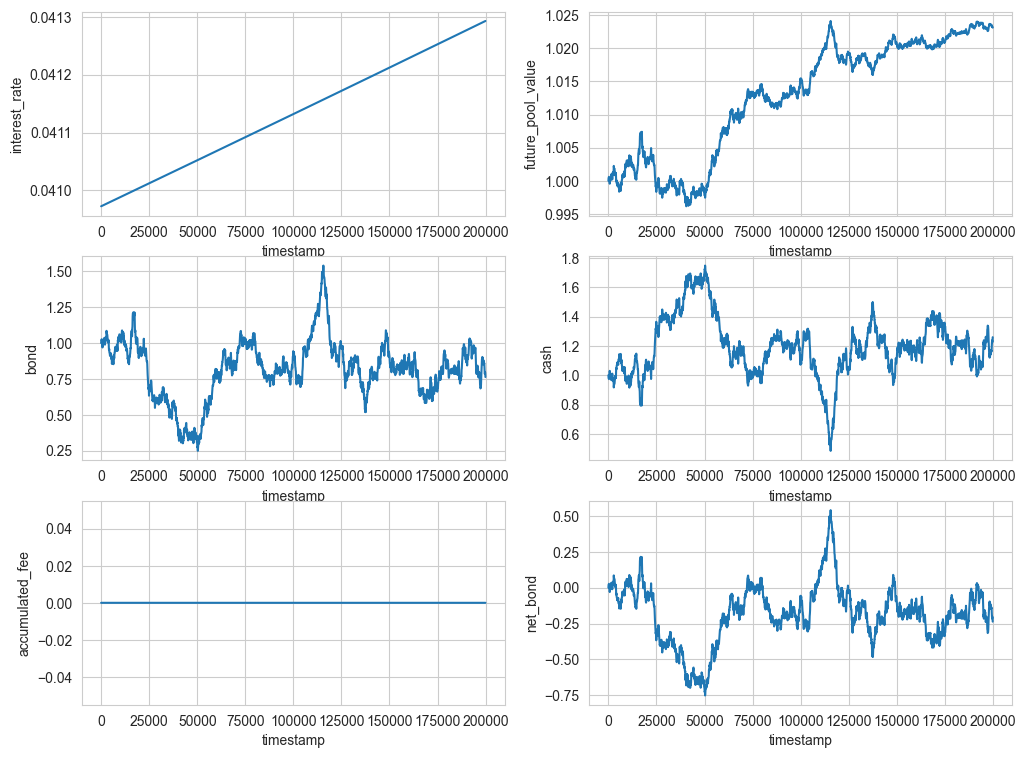

In [103]:
fig = plt.figure(figsize=(10, 8))

plot_stats('data/tracking/logit_notional/', 'ALL_INFORMATION.json', fig_size=(12, 9))

## Simulation for Linear Notional

In [36]:
%%writefile config/linear_notional_v1.yml

version_name: 'linear-notional-v1'

config:
  simulation:
    simulation_length: 200000
    begin_trade_time: 0
    maturity: 259200

  fee:
    rate: 0.

  pricing_config:
      pricing_method: 'linear-notional'
      params:
        R_MIN: 0.01
        R_MAX: 0.1

  trader:
    trade_data: 'sources/input/actor_trade/single_trade.csv'

  tracking:
    dir: 'data/tracking/linear_notional'



Overwriting config/linear_notional_v1.yml


In [37]:
with open('config/linear_notional_v1.yml') as file:
    metadata = yaml.safe_load(file)

simulator = NaiveTradeSimulator(metadata['config'])
simulator.run()

Initialized simulation!

------------- Begin running simulation -------------


100%|████████████████████████████████████████████████████████████████████████| 200000/200000 [00:23<00:00, 8377.53it/s]



Saving tracking data to data/tracking/linear_notional

------------------ Done simulation ------------------


<Figure size 1000x800 with 0 Axes>

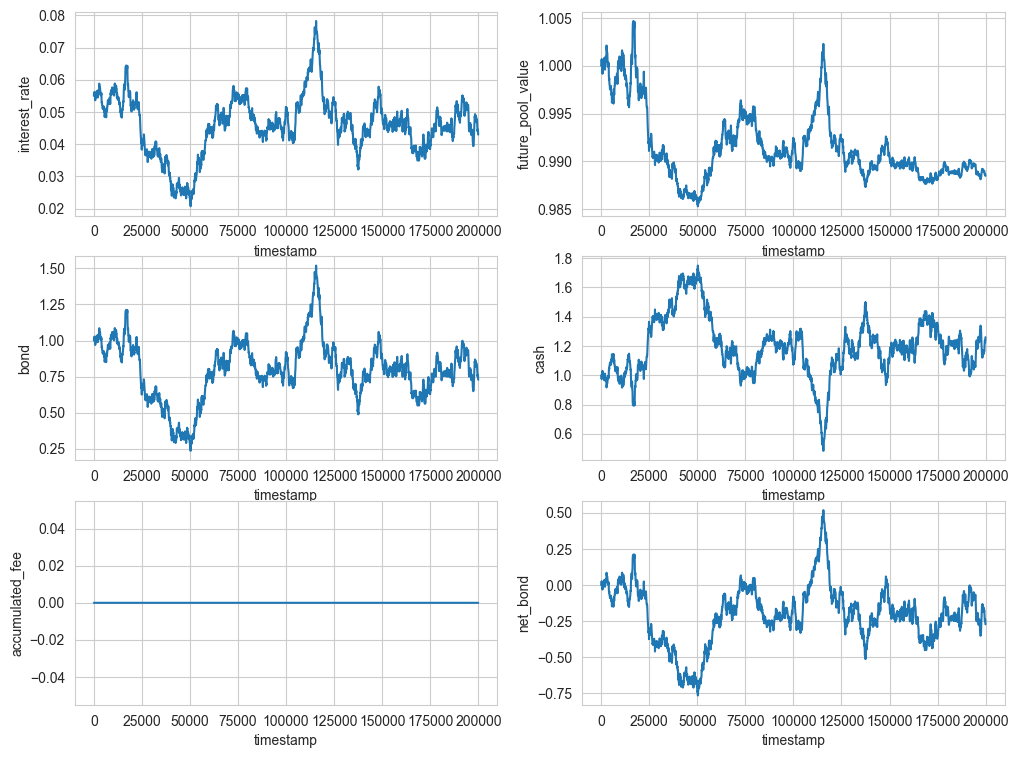

In [38]:
fig = plt.figure(figsize=(10, 8))

plot_stats('data/tracking/linear_notional', 'ALL_INFORMATION.json', fig_size=(12, 9))

## User defined price function

In [91]:
_user_defined_func_path = "scripts/price_functions/price_v1.py"

In [206]:
x, y, dx, dy, tau = 1.4959741584196584, 0.9974707942229933, 0, 0.0016086700609144, 0.4931468797564688

r_star = 0.05
kappa = 0.15

K = np.exp(-tau * r_star / (1 + tau * kappa))
alpha = 1 / (1 + tau * kappa)

r0 = kappa * np.log(K*x**(alpha)/y**(alpha)) + r_star

c1 = y * (np.exp(1/kappa * (r0 - r_star)) + 1)**(tau*kappa + 1)
c2 = c1**(1/(1 + tau*kappa))

if dx != 0:
    new_x = x + dx
    new_y = (c2 - K * new_x**alpha) ** (1 / alpha)
    dy = new_y - y
elif dy != 0:
    new_y = y + dy
    new_x = ((c2 - new_y**alpha) / K) ** (1 / alpha)
    dx = new_x - x
else:
    dy = y ** tau
    dx = x ** tau

price = abs(dy / dx)

In [228]:
np.exp(-0.05*0.5)

0.9753099120283326

In [207]:
%%writefile {_user_defined_func_path}

import numpy as np

def calculate_price(x, y, dx, dy, time_to_maturity, maturity_length) -> float:
    
    tau = time_to_maturity
    
    r_star = 0.05
    kappa = 0.02
    
    K = np.exp(-tau * r_star / (1 + tau * kappa))
    alpha = 1 / (1 + tau * kappa)
    
    r0 = kappa * np.log(K*x**(alpha)/y**(alpha)) + r_star

    c1 = y * (np.exp(1/kappa * (r0 - r_star)) + 1)**(tau*kappa + 1)
    c2 = c1**(1/(1 + tau*kappa))

    if dx != 0:
        new_x = x + dx
        new_y = (c2 - K * new_x**alpha) ** (1 / alpha)
        dy = new_y - y
    elif dy != 0:
        new_y = y + dy
        new_x = ((c2 - new_y**alpha) / K) ** (1 / alpha)
        dx = new_x - x
    else:
        dy = y ** tau
        dx = x ** tau

    price = abs(dy / dx)

    return price

Overwriting scripts/price_functions/price_v1.py


In [208]:
%%writefile config/user_defined_v1.yml

version_name: 'v1'

config:
  simulation:
    simulation_length: 200000
    begin_trade_time: 0
    maturity: 259200

  fee:
    rate: 0.

  pricing_config:
      pricing_method: 'user-defined'
      params:
        price_function: 'scripts/price_functions/price_v1.py'

  trader:
    trade_data: 'sources/input/actor_trade/single_trade.csv'

  tracking:
    dir: 'data/tracking/v1.1'

Overwriting config/user_defined_v1.yml


In [209]:
%autoreload 2

from simulation.__NaiveTradeSimulator import NaiveTradeSimulator

In [210]:
with open('config/user_defined_v1.yml') as file:
    metadata = yaml.safe_load(file)

simulator = NaiveTradeSimulator(metadata['config'])
simulator.run()

Initialized simulation!

------------- Begin running simulation -------------


100%|████████████████████████████████████████████████████████████████████████| 200000/200000 [00:53<00:00, 3754.05it/s]



Saving tracking data to data/tracking/v1.1

------------------ Done simulation ------------------


In [211]:
%autoreload 2

from scripts.generate_stats_v1 import plot_stats

<Figure size 1000x800 with 0 Axes>

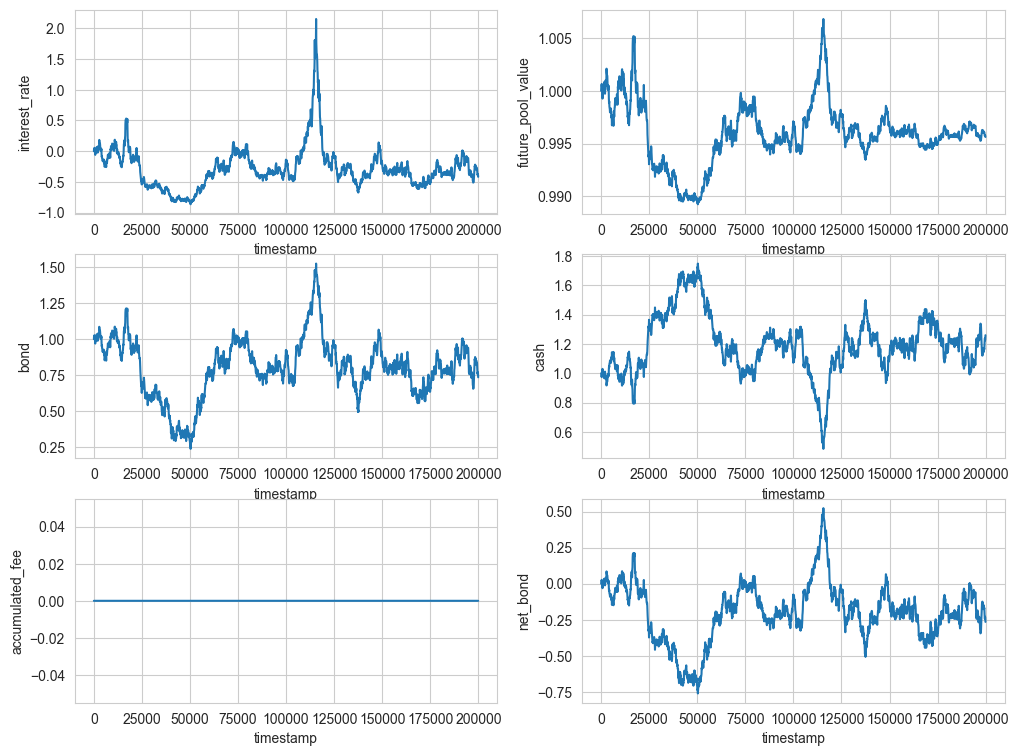

In [212]:
fig = plt.figure(figsize=(10, 8))

plot_stats('data/tracking/v1.1', 'ALL_INFORMATION.json', fig_size=(12, 9))

In [223]:
def lob_density(x, y, tau, kappa, r_star, u):
    
    K = np.exp(-tau * r_star / (1 + tau * kappa))
    alpha = 1 / (1 + tau * kappa)
    
    r0 = kappa * np.log(K*x**(alpha)/y**(alpha)) + r_star
    
    k1 = K**(-1/(tau*kappa)) * np.exp(-r0/kappa)
    
    c1 = y * (np.exp(1/kappa * (r0 - r_star)) + 1)**(tau*kappa + 1)
    c2 = c1**(1/(1 + tau*kappa))

    dx_du = -c2*(1 + tau*kappa)*k1*(1/(tau*kappa)) \
            * (K + k1*u**(1/(tau*kappa)))**(-2-tau*kappa) \
            * u**(1/(tau*kappa)-1)
    
    return -dx_du

In [224]:
kappa = 0.15
r_star = 0.05

In [225]:
price = np.linspace(0.01, 1.2, 1000)

In [226]:
x0=1
y0=1 

tau = 0.99 

lob = []

ts = [0.1, 0.5, 0.99, 5, 10]

for tau in ts: 

    lob.append(pd.DataFrame(
        {
            'density': pd.Series(lob_density(x0, y0, tau, kappa, r_star, price)),
            'price': pd.Series(price), 
            'tau': str(tau), 
            'x': x0, 
            'y': y0, 
        }
    )
    )
    
lob = pd.concat(lob)

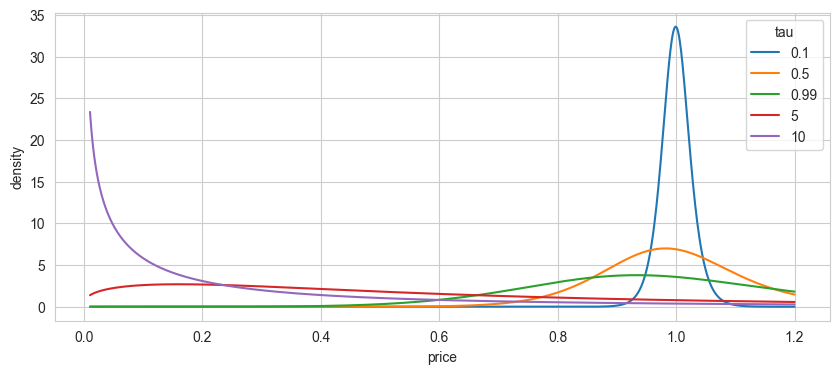

In [227]:
fig, ax = plt.subplots(figsize=(10, 4))

a = sns.lineplot(data=lob, x='price', y='density', hue='tau', palette='tab10')

# for tau, color in zip(ts, sns.color_palette('tab10')): 
#     plt.axvline(np.exp(-r_star * tau), ymin=0, ymax=0.9, color=color, 
#                 linewidth=1, linestyle='dashed')